# Problem Statement

Given the telematics data for each trip and the label if the trip is tagged as dangerous driving, derive a model that can detect dangerous driving trips.

# 1.  Preparation

## 1.1  Initialize

First, let's import the necessary libraries, initialize constants and load the data files required.

In [1]:
# !pip install imbalanced-learn -q
# !pip install lightgbm -q
# !pip install xgboost -q

In [2]:
# import libraries
import glob
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import seaborn as sns
import time
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.utils.multiclass import unique_labels

from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Bidirectional, Dense, Dropout, LSTM, GRU, Masking
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential


%matplotlib inline


# declare constants
FEATURES_DIR = './safety/features/'
LABELS_DIR = './safety/labels/'

In [3]:
def read_to_dataframe(directory):
    # A function to read all csv files within a directory and concatentate as one dataframe
    files = glob.glob(directory + '*.csv')
    return pd.concat([pd.read_csv(file) for file in files])

In [4]:
# load csv files to dataframe
features = read_to_dataframe(FEATURES_DIR)
labels = read_to_dataframe(LABELS_DIR)

In [5]:
features.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,1202590843006,3.000,353.0,1.228867,8.900100,3.986968,0.008221,0.002269,-0.009966,1362.0,0.000000
1,274877907034,9.293,17.0,0.032775,8.659933,4.737300,0.024629,0.004028,-0.010858,257.0,0.190000
2,884763263056,3.000,189.0,1.139675,9.545974,1.951334,-0.006899,-0.015080,0.001122,973.0,0.667059
3,1073741824054,3.900,126.0,3.871543,10.386364,-0.136474,0.001344,-0.339601,-0.017956,902.0,7.913285
4,1056561954943,3.900,50.0,-0.112882,10.550960,-1.560110,0.130568,-0.061697,0.161530,820.0,20.419409


## 1.2  Check for missing values and duplicates

Before we work on the data, let's check for any missing values.

In [6]:
features.isnull().sum()

bookingID         0
Accuracy          0
Bearing           0
acceleration_x    0
acceleration_y    0
acceleration_z    0
gyro_x            0
gyro_y            0
gyro_z            0
second            0
Speed             0
dtype: int64

That is a good headstart. Now, we check for the existence of duplicated bookingIDs in the labels.

In [7]:
duplicated_ids = labels[labels.bookingID.duplicated()]['bookingID']
duplicated_ids

5295      154618822837
6210     1279900254294
6516     1511828488211
10778     455266533495
11215     223338299461
12602               13
13634     970662608932
14432    1632087572573
14942    1391569403991
16340    1408749273124
16990    1348619731077
17001     695784702084
17623     403726925929
17843     515396075694
18027     481036337234
18951     919123001348
19453    1649267441751
19936     395136991308
Name: bookingID, dtype: int64

Seems like there are 18 bookingIDs that have multiple labels. We will remove these bookingIDs from the features dataset to avoid ambiguity.

In [8]:
features = features[~features['bookingID'].isin(duplicated_ids)]
labels = labels[~labels['bookingID'].isin(duplicated_ids)]

## 1.3  Check for outliers and invalid values

Let's look into each feautre to identify any outliers or invalid values. As a start, we shall look at the *second* column.

0.00    0.000000e+00
0.25    2.410000e+02
0.50    5.200000e+02
0.75    8.620000e+02
0.95    1.439000e+03
0.99    1.941000e+03
1.00    1.495797e+09
Name: second, dtype: float64

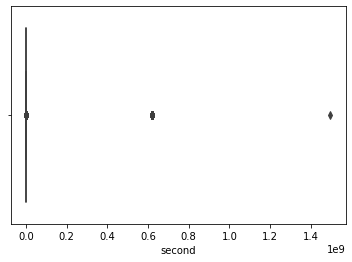

In [9]:
sns.boxplot(x=features['second']);
features['second'].quantile([0, 0.25, 0.5, 0.75, 0.95, 0.99, 1])

From the box-plot above, we can observe some extreme outliers. Now let's dig into the features dataset to understand better.

In [10]:
features.sort_values('second', ascending=False)[:90]

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
1084533,1503238553722,30.639,0.0,0.326340,9.640137,-1.966003,-0.008102,0.005890,0.003662,1.495797e+09,0.0
605392,1460288880770,6.202,0.0,0.689530,9.844957,0.881066,0.021991,0.036652,-0.065973,6.193166e+08,-1.0
91569,1460288880770,5.994,0.0,-0.114922,9.270349,0.804452,-0.202807,-0.043982,-0.012217,6.193165e+08,-1.0
150076,1460288880770,5.297,0.0,0.651223,9.385271,1.455675,0.106291,-0.467923,-0.046426,6.193165e+08,-1.0
27787,1460288880770,5.131,0.0,0.344765,9.232041,0.000000,0.134390,-0.134390,0.015882,6.193165e+08,-1.0
23972,1460288880770,5.006,0.0,0.689530,9.730036,0.421380,0.073304,0.003665,0.026878,6.193164e+08,-1.0
458973,1460288880770,5.031,0.0,0.191536,10.036493,-0.038307,0.010996,0.002443,0.174707,6.193164e+08,-1.0
1484338,1460288880770,4.482,0.0,0.651223,9.308656,1.225831,-0.131947,-0.327424,0.062308,6.193164e+08,-1.0
677926,1460288880770,4.503,0.0,0.574608,9.615114,0.497994,0.087965,-0.020769,0.064752,6.193164e+08,-1.0
964390,1460288880770,5.404,0.0,0.421380,9.346964,1.379060,-0.131947,0.032987,-0.009774,6.193164e+08,-1.0


We can see that there's a huge jump, from 8.235000e+03 to 6.193153e+08, in the *second* column.

In [11]:
features[features['bookingID'] == 1108101562401].sort_values('second', ascending=False)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
573190,1108101562401,3.678,0.0,0.928950,9.892841,3.074155,-0.194255,-0.340863,-0.109956,619315523.0,-1.000000
933235,1108101562401,3.443,0.0,0.114922,8.810662,4.596867,0.000000,0.000000,0.000000,619315503.0,-1.000000
24954,1108101562401,3.429,0.0,0.086191,8.810662,4.616021,0.000000,0.000000,0.000000,619315483.0,-1.000000
872907,1108101562401,3.118,335.0,0.833182,8.111555,5.094861,-0.003665,0.017104,-0.076969,539.0,0.000000
57482,1108101562401,3.135,335.0,0.306458,8.676587,4.970363,0.067195,0.031765,0.024435,538.0,0.000000
281280,1108101562401,3.159,335.0,0.497994,8.542512,4.759673,-0.042761,0.047647,-0.043982,537.0,0.000000
421586,1108101562401,3.192,335.0,0.363919,8.695741,4.903325,-0.026878,0.061087,0.040317,536.0,0.000000
1593197,1108101562401,3.240,335.0,0.354342,8.571242,4.845864,0.028100,0.047647,0.124617,535.0,0.000000
505030,1108101562401,3.310,335.0,0.459687,8.609549,4.884171,0.000000,0.067195,0.040317,534.0,0.441998
259123,1108101562401,3.385,306.0,0.517148,8.609549,4.922479,0.009774,0.138056,0.070860,533.0,0.000000


A further look into the trip record for a particular bookingID indicates that these rows are simply erroneous and we can remove them. Other bookingIDs with erroneous rows have the same pattern as well. We shall apply a cut-off of 9000 seconds on the *second* column.

In [12]:
features = features[features['second'] <= 9000]

Next, let's take a look at the *Speed* column.

In [13]:
features['Speed'].quantile([0, 0.25, 0.5, 0.75, 0.95, 0.99, 1])

0.00     -2.000000
0.25      1.020000
0.50      7.530000
0.75     15.480000
0.95     23.503331
0.99     26.690000
1.00    148.018630
Name: Speed, dtype: float64

As speed is a non-negative metric, we shall remove all rows in the features dataset with negative speed.

In [14]:
features = features[features['Speed'] >= 0]

Lastly, we shall focus on the *Accuracy* column.

0.00      0.750
0.25      3.900
0.50      4.024
0.75      8.000
0.95     16.000
0.99     32.000
1.00    699.999
Name: Accuracy, dtype: float64

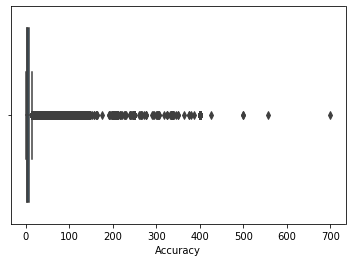

In [15]:
sns.boxplot(x=features['Accuracy']);
features['Accuracy'].quantile([0, 0.25, 0.5, 0.75, 0.95, 0.99, 1])

Similar to the previous features, we can observe quite a number of outliers in the *Accuracy* column. We shall apply a cut-off of 100m radius on the *Accuracy* column.

In [16]:
features = features[features['Accuracy'] <= 100]

To finish up, we shall exclude those trips with less than 100 data rows in the features dataset as having to few data points may not be a good representation of the particular trip. We shall also perform a sort on the telematics data to arrange the sequence properly for each unique bookingID.

In [17]:
trip_rowcount = features.groupby('bookingID').size().to_frame(name='size').reset_index()
unique_ids = trip_rowcount[trip_rowcount['size'] >= 100]['bookingID']

features = features[features['bookingID'].isin(unique_ids)]
labels = labels[labels['bookingID'].isin(unique_ids)]

features = features.sort_values(['bookingID', 'second']).reset_index(drop=True)
labels = labels.sort_values(['bookingID']).reset_index(drop=True)

# 2.  Exploratory Data Analysis

To get an initial overview, let's look at the distribution for each feature.

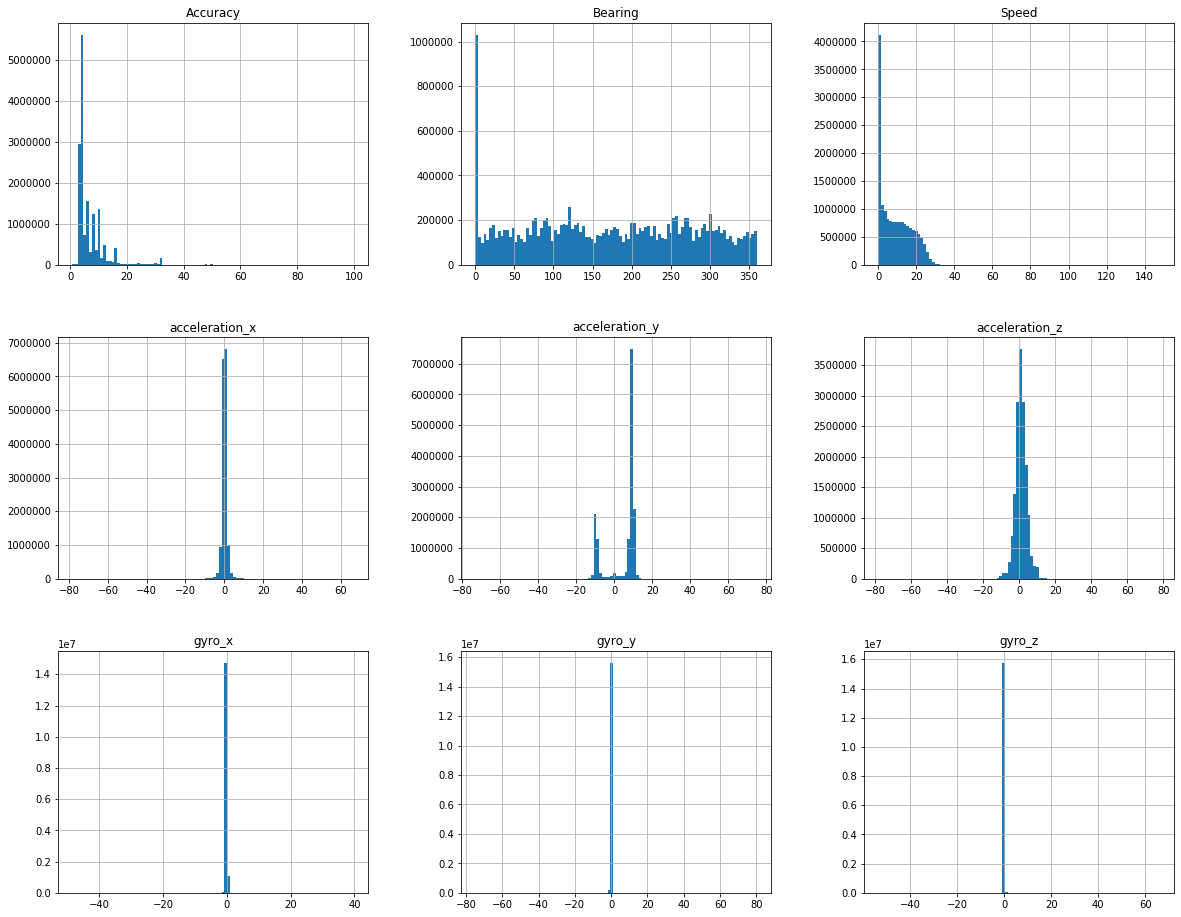

In [18]:
features.drop(['bookingID', 'second'], axis=1).hist(figsize=(20, 16), bins=100);

And below is the trip length distribution.

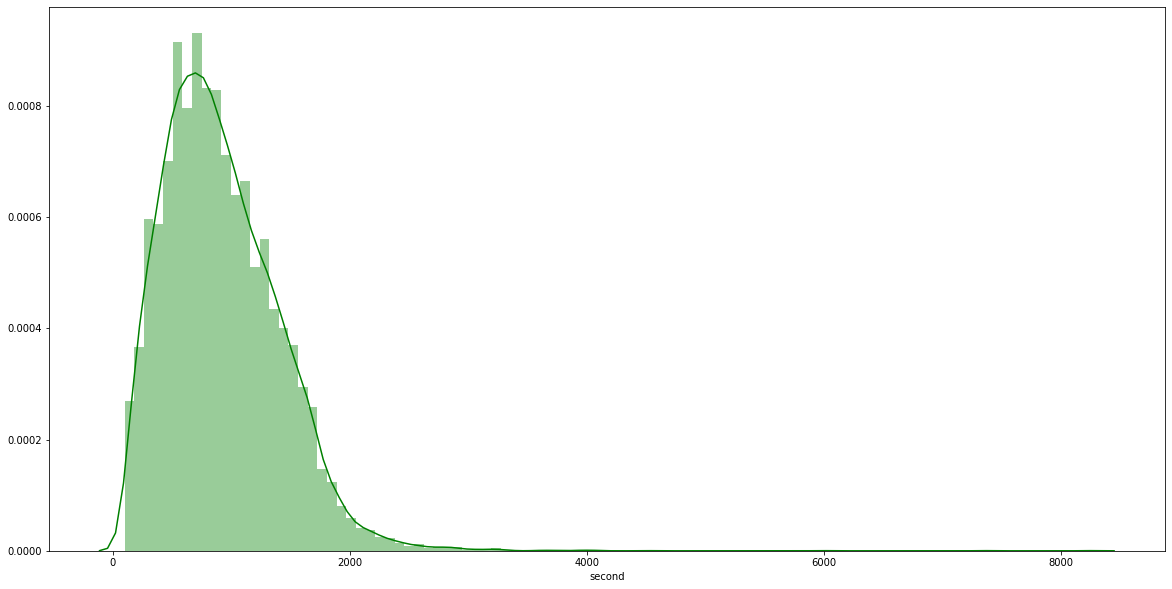

In [19]:
plt.figure(figsize=(20, 10))
sns.distplot(features.groupby('bookingID').max()['second'], color='g', bins=100);

In [20]:
features.drop(['bookingID'], axis=1).describe()

,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
count,1.586440e+07,1.586440e+07,1.586440e+07,1.586440e+07,1.586440e+07,1.586440e+07,1.586440e+07,1.586440e+07,1.586440e+07,1.586440e+07
mean,6.569186e+00,1.696938e+02,6.864850e-02,4.578809e+00,9.274216e-01,-1.665102e-03,3.108977e-04,-2.328299e-04,6.005667e+02,9.159162e+00
std,5.209433e+00,1.069862e+02,1.407471e+00,8.082564e+00,3.216468e+00,1.396545e-01,3.394635e-01,1.415096e-01,4.613757e+02,8.073446e+00
min,7.500000e-01,0.000000e+00,-7.841969e+01,-7.299412e+01,-7.844842e+01,-4.845575e+01,-7.488861e+01,-5.355445e+01,0.000000e+00,0.000000e+00
25%,3.900000e+00,7.900000e+01,-5.075862e-01,-5.291186e-01,-9.002473e-01,-2.663161e-02,-2.982208e-02,-1.865766e-02,2.410000e+02,1.264144e+00
50%,4.012000e+00,1.690000e+02,6.145935e-02,9.100265e+00,7.972935e-01,-6.230837e-04,2.663161e-04,-3.665191e-05,5.190000e+02,7.762087e+00
75%,8.000000e+00,2.630000e+02,6.343323e-01,9.713699e+00,2.766695e+00,2.322204e-02,3.123622e-02,1.814514e-02,8.610000e+02,1.561000e+01
max,1.000000e+02,3.599995e+02,6.687346e+01,7.505589e+01,7.805576e+01,3.983975e+01,8.031496e+01,6.630078e+01,8.235000e+03,1.480186e+02


The range of values for some columns are relatively wide. We'll need to scale those values later to improve model computation. Next, let's look at the distribution of labels.

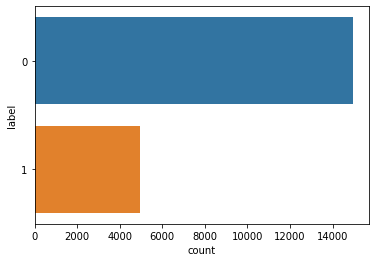

In [21]:
sns.countplot(y='label', hue=None, data=labels);

The dataset is very unbalanced. We'll need to perform some form of over/under-sampling to account for the under-representation of the outcome that we want to know, i.e. label = 1.

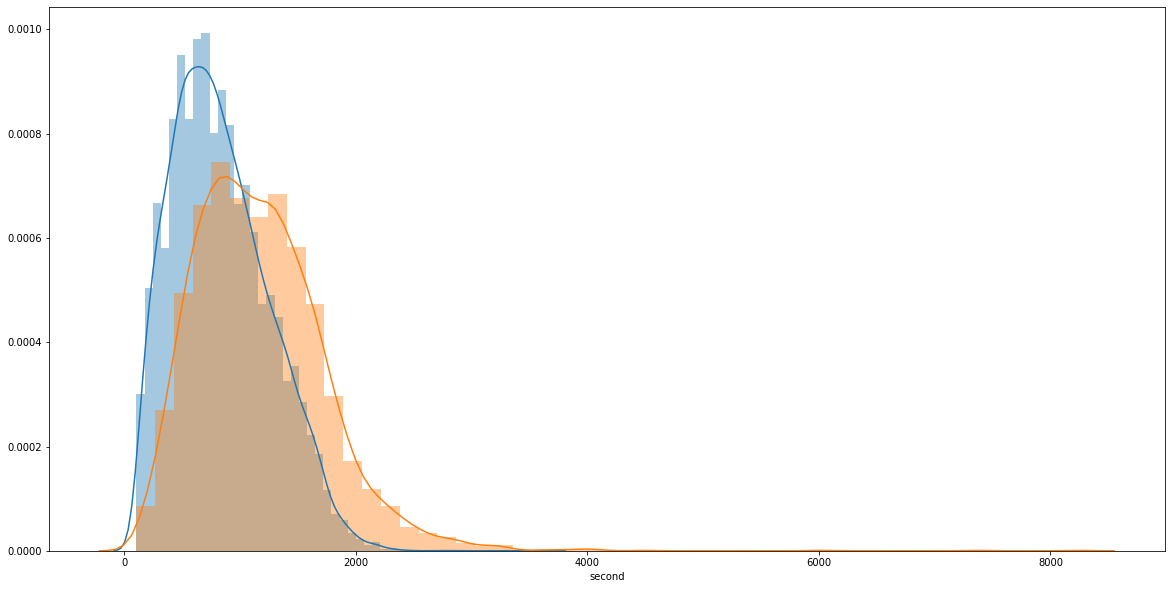

In [22]:
trip_length = pd.merge(labels, features.groupby('bookingID').max()['second'].reset_index(), on='bookingID')

plt.figure(figsize=(20, 10))
sns.distplot(trip_length[trip_length['label'] == 0]['second'], bins=50);
sns.distplot(trip_length[trip_length['label'] == 1]['second'], bins=50);

From the distribution plot above, it seems that trips that are labelled with dangerous driving are slight longer in trip duration. Now, let's check on the pairwise correlation between features.

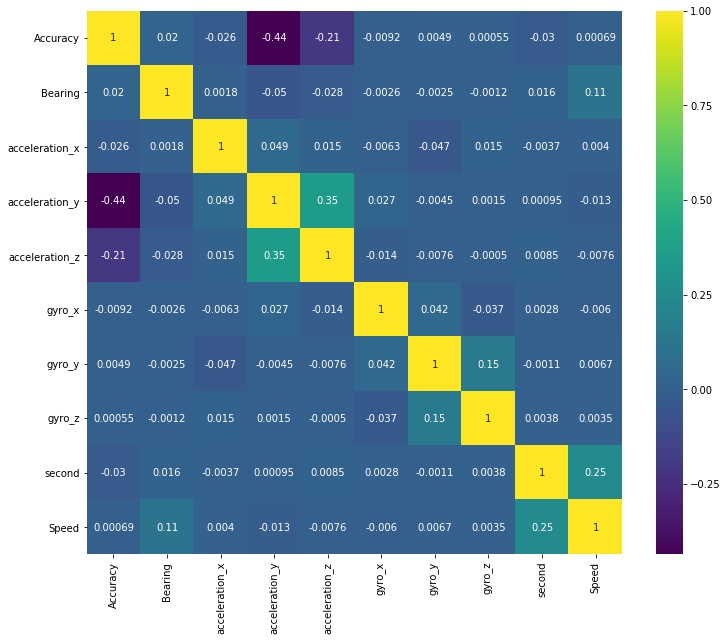

In [23]:
plt.figure(figsize=(12, 10))
sns.heatmap(features.drop(['bookingID'], axis=1).corr(), annot=True, cmap='viridis');

Generally, the correlation matrix shows mostly low correlation between each pair of features.

# 3.  Feature Engineering

As a trip contains a sequence of telematic data, we can derive new features from the original dataset to improve the modelling later. In this case, we can represent each trip with various statistical values to describe each trip, in hope that these values can help us to better identify a dangerous driving behaviour. In addition, the magnitude for acceleration and gyro are also calculated. Similarly for distance covered and change in bearing, which are more meaningful metrics compared to absolute values.

To account for the imbalanced dataset, the SMOTE technique is used to over-sample the under-represented label, namely the dangerous driving, which is our key focus here.

In [24]:
def preprocess(data, scaler=None):
    df = data.copy()
    
    # calculate total distance and magnitudes for acceleration and gyro
    distance = df.groupby('bookingID').apply(lambda group: np.trapz(group['Speed'], x=group['second'])).reset_index(name='distance')
    df['acceleration'] = np.linalg.norm(df[['acceleration_x', 'acceleration_y', 'acceleration_z']], axis=1)
    df['gyro'] = np.linalg.norm(df[['gyro_x', 'gyro_y', 'gyro_z']], axis=1)
    df['Bearing_change'] = df.groupby('bookingID')['Bearing'].diff().fillna(0)
    
    # aggregate to get statistical metrics
    df = df.groupby('bookingID').agg({'Accuracy': ['min', 'max', 'mean', 'std'],
                                      'second': ['max'],
                                      'Speed': ['min', 'max', 'mean', 'std'],
                                      'acceleration': ['min', 'max', 'mean', 'std'],
                                      'gyro': ['min', 'max', 'mean', 'std'],
                                      'Bearing_change': ['min', 'max', 'mean', 'std']}).fillna(0)
    df.columns = ['_'.join(tup).rstrip('_') for tup in df.columns.values]
    df = df.reset_index()
    
    # merge dataframes
    df = pd.merge(df, distance, on='bookingID')
    
    # apply scaler on numerical features
    num_cols = list(df.columns.drop(['bookingID']))  # get list of numerical features
    if not scaler:
        scaler = StandardScaler()
#         scaler = MinMaxScaler()
        scaler.fit(df[num_cols])
    df[num_cols] = scaler.transform(df[num_cols])
    
    return df, scaler


def rebalanced_train_test_split(data, target, test_size=0.2):
    # match each bookingID's features to corresponding label
    df = pd.merge(data, target, on='bookingID')
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['bookingID', 'label'], axis=1), df['label'],
                                                        test_size=test_size)
    
    print('Before rebalance:', y_train.value_counts(), sep='\n')
    
    # rebalance training set
    sme = SMOTE()
    X_train, y_train = sme.fit_resample(X_train, y_train)
    print('After rebalance:', np.unique(y_train, return_counts=True), sep='\n')
    
    return X_train, np.asarray(X_test), y_train, np.asarray(y_test)

In [25]:
X, scaler = preprocess(features)
X_train, X_test, y_train, y_test = rebalanced_train_test_split(X, labels)

Before rebalance:
0    11988
1     3966
Name: label, dtype: int64
After rebalance:
(array([0, 1], dtype=int64), array([11988, 11988], dtype=int64))


The scaler will be serialized as a pickle object for easy retrival.

In [26]:
# Save to file in the current working directory
pkl_scaler_filename = "pickle_scaler.pkl"
with open(pkl_scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

# 4.  Modelling

## 4.1  ML model

We shall train 3 different binary classification models and perform validation test on each of these models. The 3 models are:
* Light-GBM Classifier
* Logistic Regression
* Support Vector Classifier

10-fold CV with grid search is applied to obtain the best possible model. For this approach, PCA is not applied as it yielded a significantly lower AUC across all models despite the reduction in feature dimension.

In [27]:
def run_model(estimator_dict, X_train, X_test, y_train, y_test, with_pca=False):
    cv_model_dict = {}
    prediction_dict = {}
    best_score = 0
    
    # train each model
    for model_name, clf in estimator_dict.items():
        print('Running', model_name, 'model...')
        
        # check if use of PCA is required
        if with_pca:
            pipeline = Pipeline([('pca', PCA(n_components=2)), ('clf', clf)])
        else:
            pipeline = Pipeline([('clf', clf)])

        cv_clf = cv_model_dict[model_name] = GridSearchCV(estimator=pipeline, param_grid=[{}], scoring='roc_auc',
                                                          cv=10, n_jobs=-1)

        # fit classification model
        cv_clf.fit(X_train, y_train)
        
        # predict on X_test
        prediction_dict[model_name] = cv_clf.predict(X_test)
        
        test_score = cv_clf.score(X_test, y=y_test)
        print('Train score: {}'.format(cv_clf.score(X_train, y=y_train)))
        print('Test score: {}\n'.format(test_score))
        
        if test_score > best_score:
            best_score = test_score
            best_model = model_name
    
    print('The model with the best test score is {}'.format(best_model))
    return cv_model_dict, prediction_dict, best_model

In [28]:
estimators = {
    'LGBMClassifier': lgb.LGBMClassifier(n_estimators=100, random_state=42),
    'LogisticRegression': LogisticRegression(solver='lbfgs', random_state=42),
    'SVC': SVC(gamma='auto', probability=True, random_state=42),
#     'RandomForestClassifier': RandomForestClassifier(n_estimators=100, random_state=42),
#     'XGBClassifier': xgb.XGBClassifier(n_estimators=100, random_state=42)
}

cv_models, predictions, best_model = run_model(estimators, X_train, X_test, y_train, y_test)

Running LGBMClassifier model...
Train score: 0.9270360965458841
Test score: 0.70169768430638

Running LogisticRegression model...
Train score: 0.7268265304009381
Test score: 0.7146993146993148

Running SVC model...
Train score: 0.7825993744829247
Test score: 0.7078754339623905

The model with the best test score is LogisticRegression


The best model will be serialized as a pickle object for easy retrival.

In [29]:
# Save to file in the current working directory
pkl_model_filename = "pickle_model.pkl"
with open(pkl_model_filename, 'wb') as file:
    pickle.dump(cv_models[best_model], file)

Based on just the absolute scores above, we observe that the logistic regression model performed the best overall, having the highest test score. Also, we note that the difference between the train and test scores for the other 2 models are significantly stark, which suggests overfitting during the training phase. We shall take a look in further details on the prediction results.

Across the 3 models, the ROC-AUC scores are pretty close, with an approximate difference of 0.01.

In [30]:
def plot_roc_curve(cv_model_dict, X_test, y_test):
    # initialize figure size
    plt.figure(figsize=(20, 15))
    
    # plot ROC curve for each model
    for model_name, clf in cv_model_dict.items():
        y_score = clf.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='%s ROC curve (area = %0.4f)' % (model_name, roc_auc))
    
    # display plot
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    
    plt.show()
    return

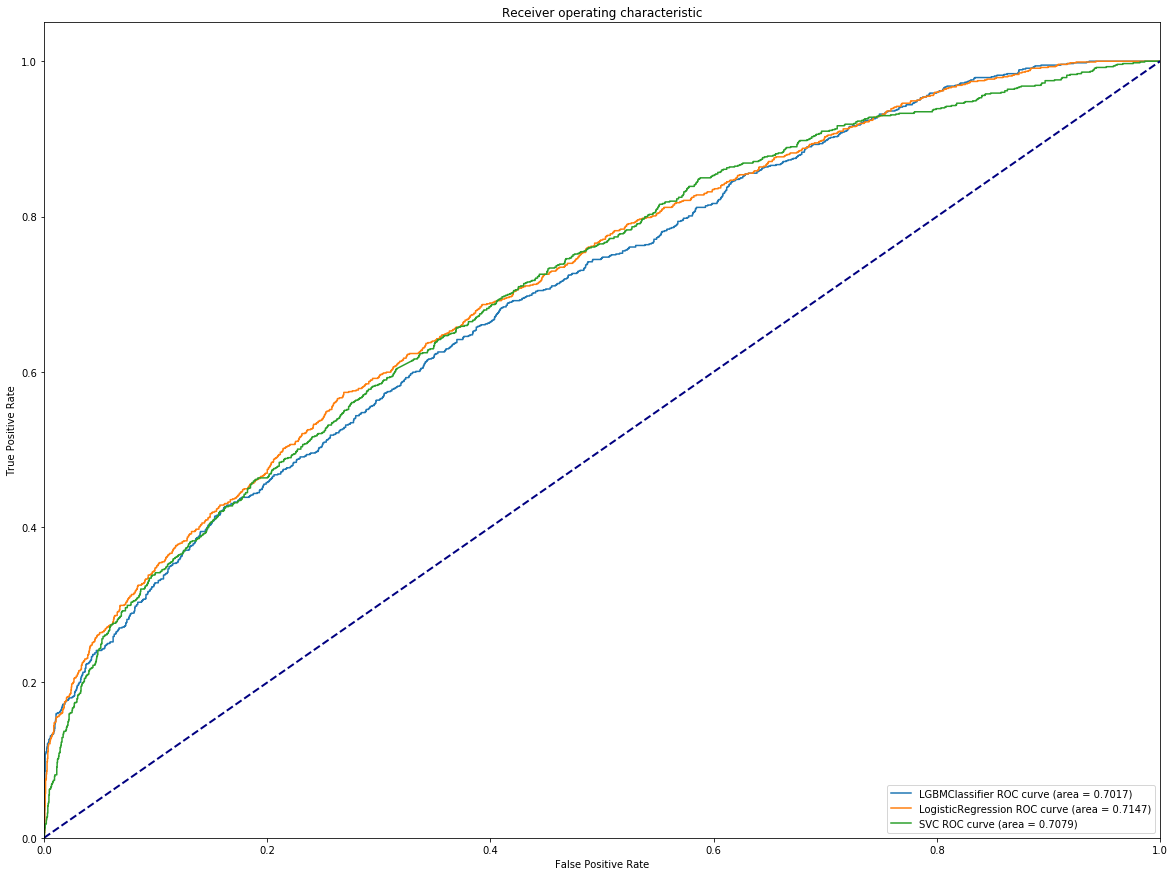

In [31]:
plot_roc_curve(cv_models, X_test, y_test)

The classification report below provides a more detailed breakdown on the prediction results. While the difference in scores between all 3 models are quite small, the logistic regression model is more preferred since it has the highest precision score and it is not overfitted. Also, the interpretability of the model is comparatively easier as well.

In [32]:
def generate_all_report(prediction_dict, y_test):
    for model_name, y_pred in prediction_dict.items():
        print(model_name, '\n', classification_report(y_test, y_pred, unique_labels(y_test, y_pred)))

In [33]:
generate_all_report(predictions, y_test)

LGBMClassifier 
               precision    recall  f1-score   support

           0       0.81      0.83      0.82      2990
           1       0.45      0.43      0.44       999

   micro avg       0.73      0.73      0.73      3989
   macro avg       0.63      0.63      0.63      3989
weighted avg       0.72      0.73      0.73      3989

LogisticRegression 
               precision    recall  f1-score   support

           0       0.84      0.68      0.75      2990
           1       0.39      0.62      0.48       999

   micro avg       0.66      0.66      0.66      3989
   macro avg       0.62      0.65      0.61      3989
weighted avg       0.73      0.66      0.68      3989

SVC 
               precision    recall  f1-score   support

           0       0.84      0.68      0.75      2990
           1       0.39      0.61      0.47       999

   micro avg       0.66      0.66      0.66      3989
   macro avg       0.61      0.64      0.61      3989
weighted avg       0.73      0

In [34]:
def plot_confusion_matrix(ax, y_true, y_pred, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    return ax


def plot_all_cm(prediction_dict, y_test, nrows, ncols):
    np.set_printoptions(precision=2)
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=(20, 5))
    idx = 0
    
    for model_name, y_pred in prediction_dict.items():
        # Plot non-normalized confusion matrix
        plot_confusion_matrix(ax[idx // ncols, idx % ncols], y_test, y_pred, title=model_name + ' Confusion Matrix')
        idx += 1

    for i in range(idx, nrows * ncols):
        fig.delaxes(ax[idx // ncols, idx % ncols])

    fig.tight_layout()
    plt.show()
    return

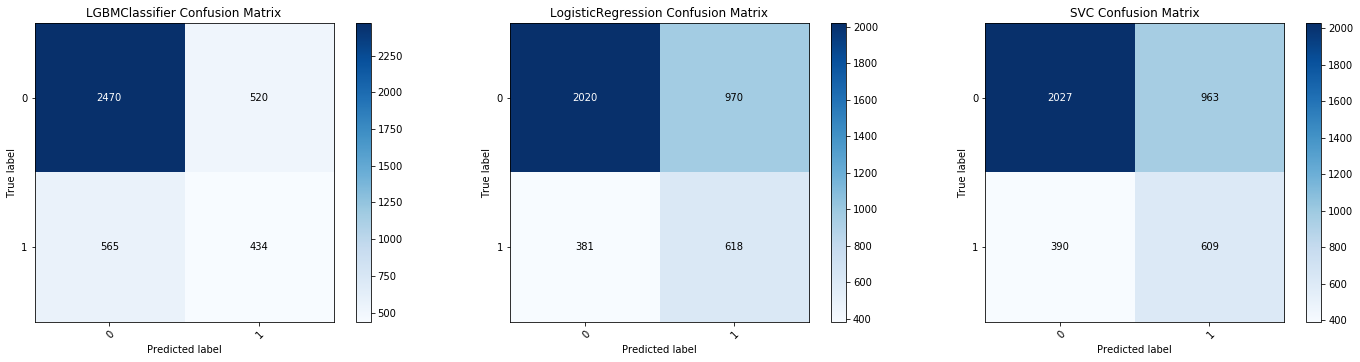

In [35]:
plot_all_cm(predictions, y_test, 1, 3)

## 4.2  Sequential Model

To go a bit further from the traditional machine learning model, we shall look at neural network, particularly the RNN model since we are dealing with sequence dataset. For this particular model, the data points are not aggregated to each booking trip, but rather, being treated as is given originally. Similar to previous method, the imbalanced dataset is accounted for by using oversampling on the under-represented label.

The model we are using is a bi-directional GRU neural network, where this structure allows the network to have both backward and forward information about the sequence at every time step. Masking is also applied due to the variational time step for each trip.

In [36]:
def seq_preprocess(data, window=30, scaler=None):
    df = data.copy()

    # compute additional features
    df['acceleration'] = np.linalg.norm(df[['acceleration_x', 'acceleration_y', 'acceleration_z']], axis=1)
    df['gyro'] = np.linalg.norm(df[['gyro_x', 'gyro_y', 'gyro_z']], axis=1)
    df['distance'] = df.groupby('bookingID')['second'].diff().fillna(0) * df['Speed']
    df['Bearing_change'] = df.groupby('bookingID')['Bearing'].diff().fillna(0)

    # apply moving average for each bookingID
    df['bin'] = df.groupby('bookingID').cumcount() // window
    df = df.groupby(['bookingID', 'bin']).mean().reset_index()

    # drop unnecessary features
    df = df.drop(['Bearing', 'acceleration_x', 'acceleration_y', 'acceleration_z',
                  'gyro_x', 'gyro_y', 'gyro_z', 'second', 'Speed', 'bin'], axis=1)

    # apply scaler on numerical features
    num_cols = list(df.columns.drop(['bookingID']))  # get list of numerical features
    if not scaler:
    #     scaler = StandardScaler()
        scaler = MinMaxScaler()
        scaler.fit(df[num_cols])
    df[num_cols] = scaler.transform(df[num_cols])

    # calculate number of features and max timestep
    feature_len = len(df.drop(['bookingID'], axis=1).columns)
    max_timestep = df.groupby('bookingID').size().max()

    return df, scaler, feature_len, max_timestep


def seq_rebalanced_train_test_split(data, target, test_size=0.2, balance=True):
    # transform data to 'tensor' shape
    group = data.groupby('bookingID').cumcount()
    X = (data.set_index(['bookingID', group])
             .unstack(fill_value=0)
             .stack().groupby(level=0)
             .apply(lambda x: x.values.tolist())
             .tolist())
    y = target['label'].values.tolist()
    
    # get train and test indices
    test_len = int(len(target.index) * test_size)
    test_indices = random.sample(list(target.index), test_len)
    train_indices = list(set(list(target.index)) - set(test_indices))
    
    if balance:
        # balance dataset for training set
        train_labels = target[target.index.isin(train_indices)]
        train_label_0 = list(train_labels[train_labels['label'] == 0].index)    
        train_label_1 = list(train_labels[train_labels['label'] == 1].index)
        print('Before rebalance:', '0: {}\n1: {}'.format(len(train_label_0), len(train_label_1)), sep='\n')

        train_label_1 = random.choices(train_label_1, k=len(train_label_0))
        train_indices = train_label_0 + train_label_1
        print('After rebalance:', '0: {}\n1: {}\n'.format(len(train_label_0), len(train_label_1)), sep='\n')
    
    # split data into training and test set
    X_train = np.asarray([X[i] for i in train_indices])
    X_test = np.asarray([X[i] for i in test_indices])
    y_train = np.asarray([y[i] for i in train_indices])
    y_test = np.asarray([y[i] for i in test_indices])
    
    print('X_train shape:', X_train.shape)
    print('y_train shape:', y_train.shape)
    print('X_test shape:', X_test.shape)
    print('y_test shape:', y_test.shape)
    return X_train, X_test, y_train, y_test


def build_model(feature_len, max_timestep, num_class=1, filepath=None):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(max_timestep, feature_len)))
    model.add(Bidirectional(GRU(units=128, dropout=0.2, input_shape=(None, max_timestep, feature_len), return_sequences=False)))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(rate=0.4))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(rate=0.4))
    model.add(Dense(units=num_class, activation='sigmoid'))
    
    if filepath:
        model.load_weights(filepath)
    
    start = time.time()
    model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=['accuracy'])
    
    print('Compilation Time:', time.time() - start)
    print(model.summary())
    return model

In [37]:
nn_X, nn_scaler, feature_len, max_timestep = seq_preprocess(features)
nn_X_train, nn_X_test, nn_y_train, nn_y_test = seq_rebalanced_train_test_split(nn_X, labels, 0.2)

Before rebalance:
0: 12017
1: 3938
After rebalance:
0: 12017
1: 12017

X_train shape: (24034, 251, 5)
y_train shape: (24034,)
X_test shape: (3988, 251, 5)
y_test shape: (3988,)


In [38]:
# build model
weights_filepath = 'weights.best.hdf5'
model = build_model(feature_len, max_timestep)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Compilation Time: 0.1213228702545166
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 251, 5)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               102912    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
__

In [40]:
# initialize checkpoint and early stopping
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto',
                              baseline=None, restore_best_weights=True)

# train model
history = model.fit(nn_X_train, nn_y_train, batch_size=128, epochs=200, validation_data=(nn_X_test, nn_y_test),
                    verbose=1, callbacks=[checkpoint, earlystopping])

Train on 24034 samples, validate on 3988 samples
Epoch 1/200
23936/24034 [============================>.] - ETA: 0s - loss: 0.6818 - acc: 0.5564
Epoch 00001: val_loss improved from inf to 0.71245, saving model to weights.best.hdf5
24034/24034 [==============================] - 143s 6ms/sample - loss: 0.6820 - acc: 0.5561 - val_loss: 0.7124 - val_acc: 0.5123
Epoch 2/200
23936/24034 [============================>.] - ETA: 0s - loss: 0.6690 - acc: 0.5896
Epoch 00002: val_loss improved from 0.71245 to 0.65612, saving model to weights.best.hdf5
24034/24034 [==============================] - 154s 6ms/sample - loss: 0.6689 - acc: 0.5899 - val_loss: 0.6561 - val_acc: 0.6299
Epoch 3/200
23936/24034 [============================>.] - ETA: 0s - loss: 0.6656 - acc: 0.5983
Epoch 00003: val_loss did not improve from 0.65612
24034/24034 [==============================] - 143s 6ms/sample - loss: 0.6656 - acc: 0.5984 - val_loss: 0.6748 - val_acc: 0.5908
Epoch 4/200
23936/24034 [========================

Epoch 30/200
23936/24034 [============================>.] - ETA: 0s - loss: 0.6493 - acc: 0.6136
Epoch 00030: val_loss did not improve from 0.61231
24034/24034 [==============================] - 138s 6ms/sample - loss: 0.6492 - acc: 0.6138 - val_loss: 0.6396 - val_acc: 0.6968
Epoch 31/200
23936/24034 [============================>.] - ETA: 0s - loss: 0.6558 - acc: 0.6075
Epoch 00031: val_loss did not improve from 0.61231
24034/24034 [==============================] - 138s 6ms/sample - loss: 0.6559 - acc: 0.6074 - val_loss: 0.6250 - val_acc: 0.6923
Epoch 32/200
23936/24034 [============================>.] - ETA: 0s - loss: 0.6519 - acc: 0.6090
Epoch 00032: val_loss did not improve from 0.61231
24034/24034 [==============================] - 137s 6ms/sample - loss: 0.6518 - acc: 0.6092 - val_loss: 0.7103 - val_acc: 0.5441
Epoch 33/200
23936/24034 [============================>.] - ETA: 0s - loss: 0.6508 - acc: 0.6115
Epoch 00033: val_loss did not improve from 0.61231
24034/24034 [========

Epoch 60/200
23936/24034 [============================>.] - ETA: 0s - loss: 0.6335 - acc: 0.6237
Epoch 00060: val_loss did not improve from 0.59731
24034/24034 [==============================] - 136s 6ms/sample - loss: 0.6335 - acc: 0.6239 - val_loss: 0.6294 - val_acc: 0.6412
Epoch 61/200
23936/24034 [============================>.] - ETA: 0s - loss: 0.6337 - acc: 0.6248
Epoch 00061: val_loss did not improve from 0.59731
24034/24034 [==============================] - 137s 6ms/sample - loss: 0.6336 - acc: 0.6249 - val_loss: 0.5998 - val_acc: 0.7034
Epoch 62/200
23936/24034 [============================>.] - ETA: 0s - loss: 0.6366 - acc: 0.6212
Epoch 00062: val_loss did not improve from 0.59731
24034/24034 [==============================] - 137s 6ms/sample - loss: 0.6365 - acc: 0.6213 - val_loss: 0.6196 - val_acc: 0.6733
Epoch 63/200
23936/24034 [============================>.] - ETA: 0s - loss: 0.6336 - acc: 0.6246
Epoch 00063: val_loss did not improve from 0.59731
24034/24034 [========

23936/24034 [============================>.] - ETA: 0s - loss: 0.6215 - acc: 0.6358
Epoch 00089: val_loss did not improve from 0.57926
24034/24034 [==============================] - 146s 6ms/sample - loss: 0.6216 - acc: 0.6357 - val_loss: 0.6096 - val_acc: 0.6642
Epoch 90/200
23936/24034 [============================>.] - ETA: 0s - loss: 0.6188 - acc: 0.6360
Epoch 00090: val_loss did not improve from 0.57926
24034/24034 [==============================] - 150s 6ms/sample - loss: 0.6188 - acc: 0.6360 - val_loss: 0.6105 - val_acc: 0.6993
Epoch 91/200
23936/24034 [============================>.] - ETA: 0s - loss: 0.6189 - acc: 0.6374
Epoch 00091: val_loss did not improve from 0.57926
24034/24034 [==============================] - 143s 6ms/sample - loss: 0.6190 - acc: 0.6371 - val_loss: 0.6273 - val_acc: 0.6507
Epoch 92/200
23936/24034 [============================>.] - ETA: 0s - loss: 0.6197 - acc: 0.6354
Epoch 00092: val_loss did not improve from 0.57926
24034/24034 [=====================

Epoch 119/200
23936/24034 [============================>.] - ETA: 0s - loss: 0.5968 - acc: 0.6576
Epoch 00119: val_loss did not improve from 0.57926
24034/24034 [==============================] - 150s 6ms/sample - loss: 0.5969 - acc: 0.6574 - val_loss: 0.6456 - val_acc: 0.6269
Epoch 120/200
23936/24034 [============================>.] - ETA: 0s - loss: 0.5973 - acc: 0.6596
Epoch 00120: val_loss did not improve from 0.57926
24034/24034 [==============================] - 149s 6ms/sample - loss: 0.5973 - acc: 0.6595 - val_loss: 0.6107 - val_acc: 0.6916
Epoch 121/200
23936/24034 [============================>.] - ETA: 0s - loss: 0.5981 - acc: 0.6603
Epoch 00121: val_loss did not improve from 0.57926
24034/24034 [==============================] - 153s 6ms/sample - loss: 0.5982 - acc: 0.6603 - val_loss: 0.6066 - val_acc: 0.6948
Epoch 122/200
23936/24034 [============================>.] - ETA: 0s - loss: 0.5946 - acc: 0.6598
Epoch 00122: val_loss did not improve from 0.57926
24034/24034 [====

In [41]:
def plot_model_loss(model):
    fig, ax = plt.subplots(figsize=(20, 10))

    plt.plot(model.history.history['loss'], label='Training loss')
    plt.plot(model.history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    
    plt.show()
    return

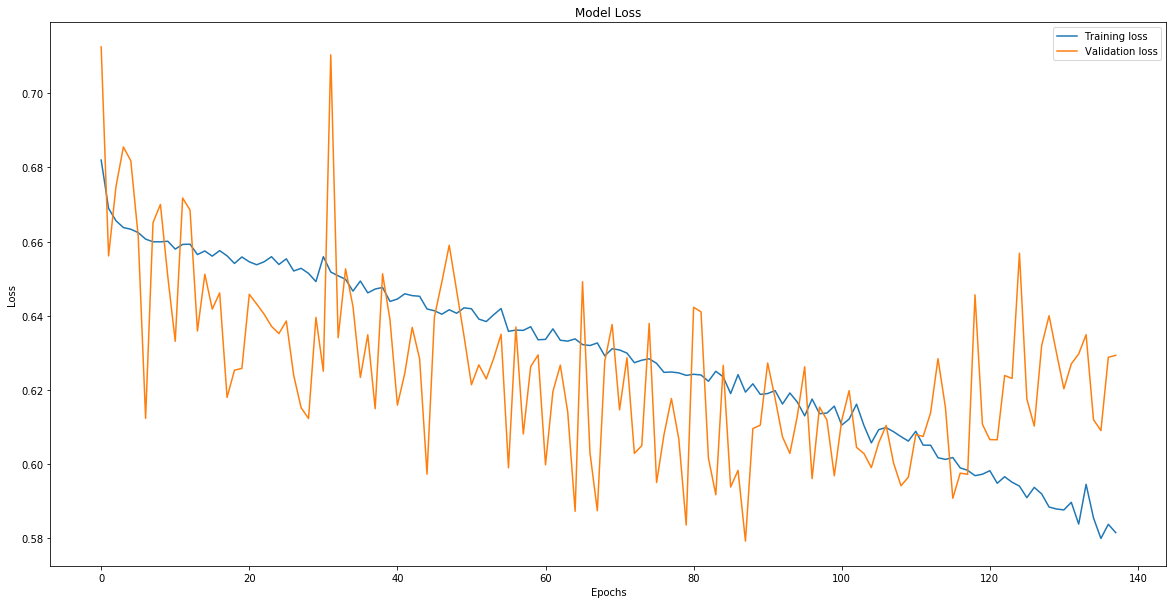

In [42]:
plot_model_loss(model)

From the results, the neural network had similar performance as compared to the Light-GBM model in terms of ROC-AUC score as well as the other classification metrics. Also, the validation loss is highly unstable as compared to the training loss, which is decreasing gradually.

In [43]:
def generate_model_results(model, X_test, y_test, model_name):
    # initialize figure size
    fig, ax = plt.subplots(ncols=2, squeeze=False, figsize=(20, 10))
    ax1, ax2 = ax.flatten()

    # plot ROC curve for NN
    y_score = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, label='%s ROC curve (area = %0.4f)' % (model_name, roc_auc))

    # display plot
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver operating characteristic')
    ax1.legend(loc="lower right")

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(ax2, y_test, (y_score > 0.5), title=model_name + ' Confusion Matrix')

    fig.tight_layout()
    plt.show()
    
    print(model_name, '\n', classification_report(y_test, (y_score > 0.5)))
    return

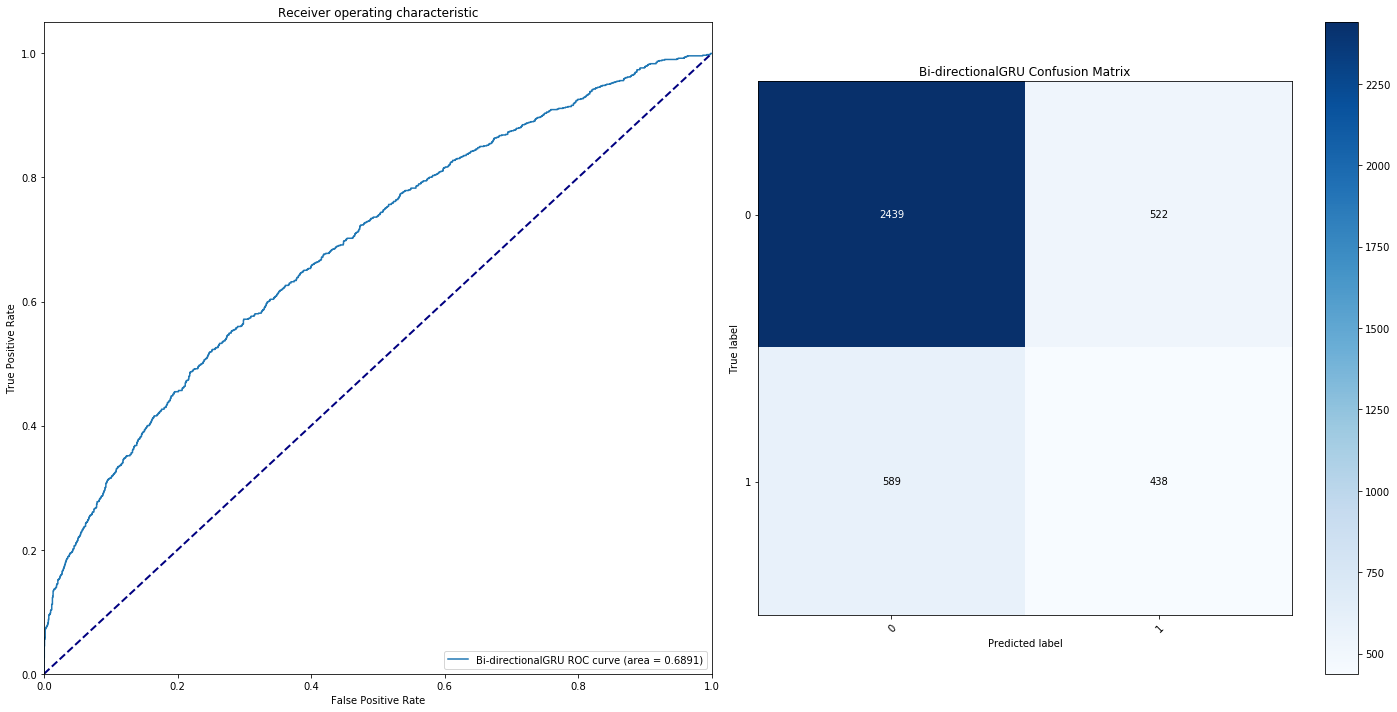

Bi-directionalGRU 
               precision    recall  f1-score   support

           0       0.81      0.82      0.81      2961
           1       0.46      0.43      0.44      1027

   micro avg       0.72      0.72      0.72      3988
   macro avg       0.63      0.63      0.63      3988
weighted avg       0.72      0.72      0.72      3988



In [44]:
generate_model_results(model, nn_X_test, nn_y_test, 'Bi-directionalGRU')

# 5.  Conclusion

Overall, the logistic regression model is preferred due to its performance, with the highest ROC-AUC score of 0.7, while at the same time having a greater interpretability as compared to the other trained models. However, a roc-auc score of this magnitude may not be suitable for production-level deployment. To improve the model performance, more information needs to be known such as the exact location (e.g. latitude and longitude). Coupuled with traffic and maps data, these data will certainly help to improve the model. As the saying goes, "_garbage in, garbage out_".

# Appendix

To run the same prediction model on the test data, simply run the function below. The directories for the test features and labels have to be provided.

In [ ]:
def run_test(test_features_dir, test_labels_dir, scaler, clf):
    # read test data
    test_features = read_to_dataframe(test_features_dir)
    test_labels = read_to_dataframe(test_labels_dir)
    
    # remove trips with conflicting labels
    duplicated_ids = test_labels[test_labels.bookingID.duplicated()]['bookingID']
    test_features = test_features[~test_features['bookingID'].isin(duplicated_ids)]
    test_labels = test_labels[~test_labels['bookingID'].isin(duplicated_ids)]
    
    # sort dataset by bookingID and second
    test_features = test_features.sort_values(['bookingID', 'second']).reset_index(drop=True)
    test_labels = test_labels.sort_values(['bookingID']).reset_index(drop=True)
    
    # pre-processing
    test_X, _ = preprocess(test_features, scaler)
    test_y = test_labels['label']
    
    # model prediction
    test_pred = clf.predict(test_X.drop(['bookingID'], axis=1))
    print('Test score: {}\n'.format(clf.score(test_X.drop(['bookingID'], axis=1), y=test_y)))
    return test_X, test_y, test_pred

In [ ]:
# uncomment lines below to run the test function
# TEST_FEATURES_DIR = ''
# TEST_LABELS_DIR = ''

# with open(pkl_scaler_filename, 'rb') as file:
#     pickle_scaler = pickle.load(file)

# with open(pkl_model_filename, 'rb') as file:
#     pickle_model = pickle.load(file)

# test_X, test_y, test_pred = run_test(TEST_FEATURES_DIR, TEST_LABELS_DIR, pickle_scaler, pickle_model)

The code below provides an alternative for using ROC-AUC score as the metric to monitor instead of the usual accuracy metric when running a neural network model.

In [ ]:
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return